c:\Users\Lou\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Données chargées: 1199 observations d'août 2019 à novembre 2022
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       347
        True       1.00      0.92      0.96        13

    accuracy                           1.00       360
   macro avg       1.00      0.96      0.98       360
weighted avg       1.00      1.00      1.00       360

Anomalies DBSCAN: 56
Anomalies RandomForest: 42
Anomalies composites: 48


20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing


Prévision Prophet créée pour 30 jours
69 périodes à risque critique identifiées
Features les plus pertinentes:
   • Opening Amount: 0.9907
   • MACD: 0.0058
   • Volatility_Pct: 0.0015


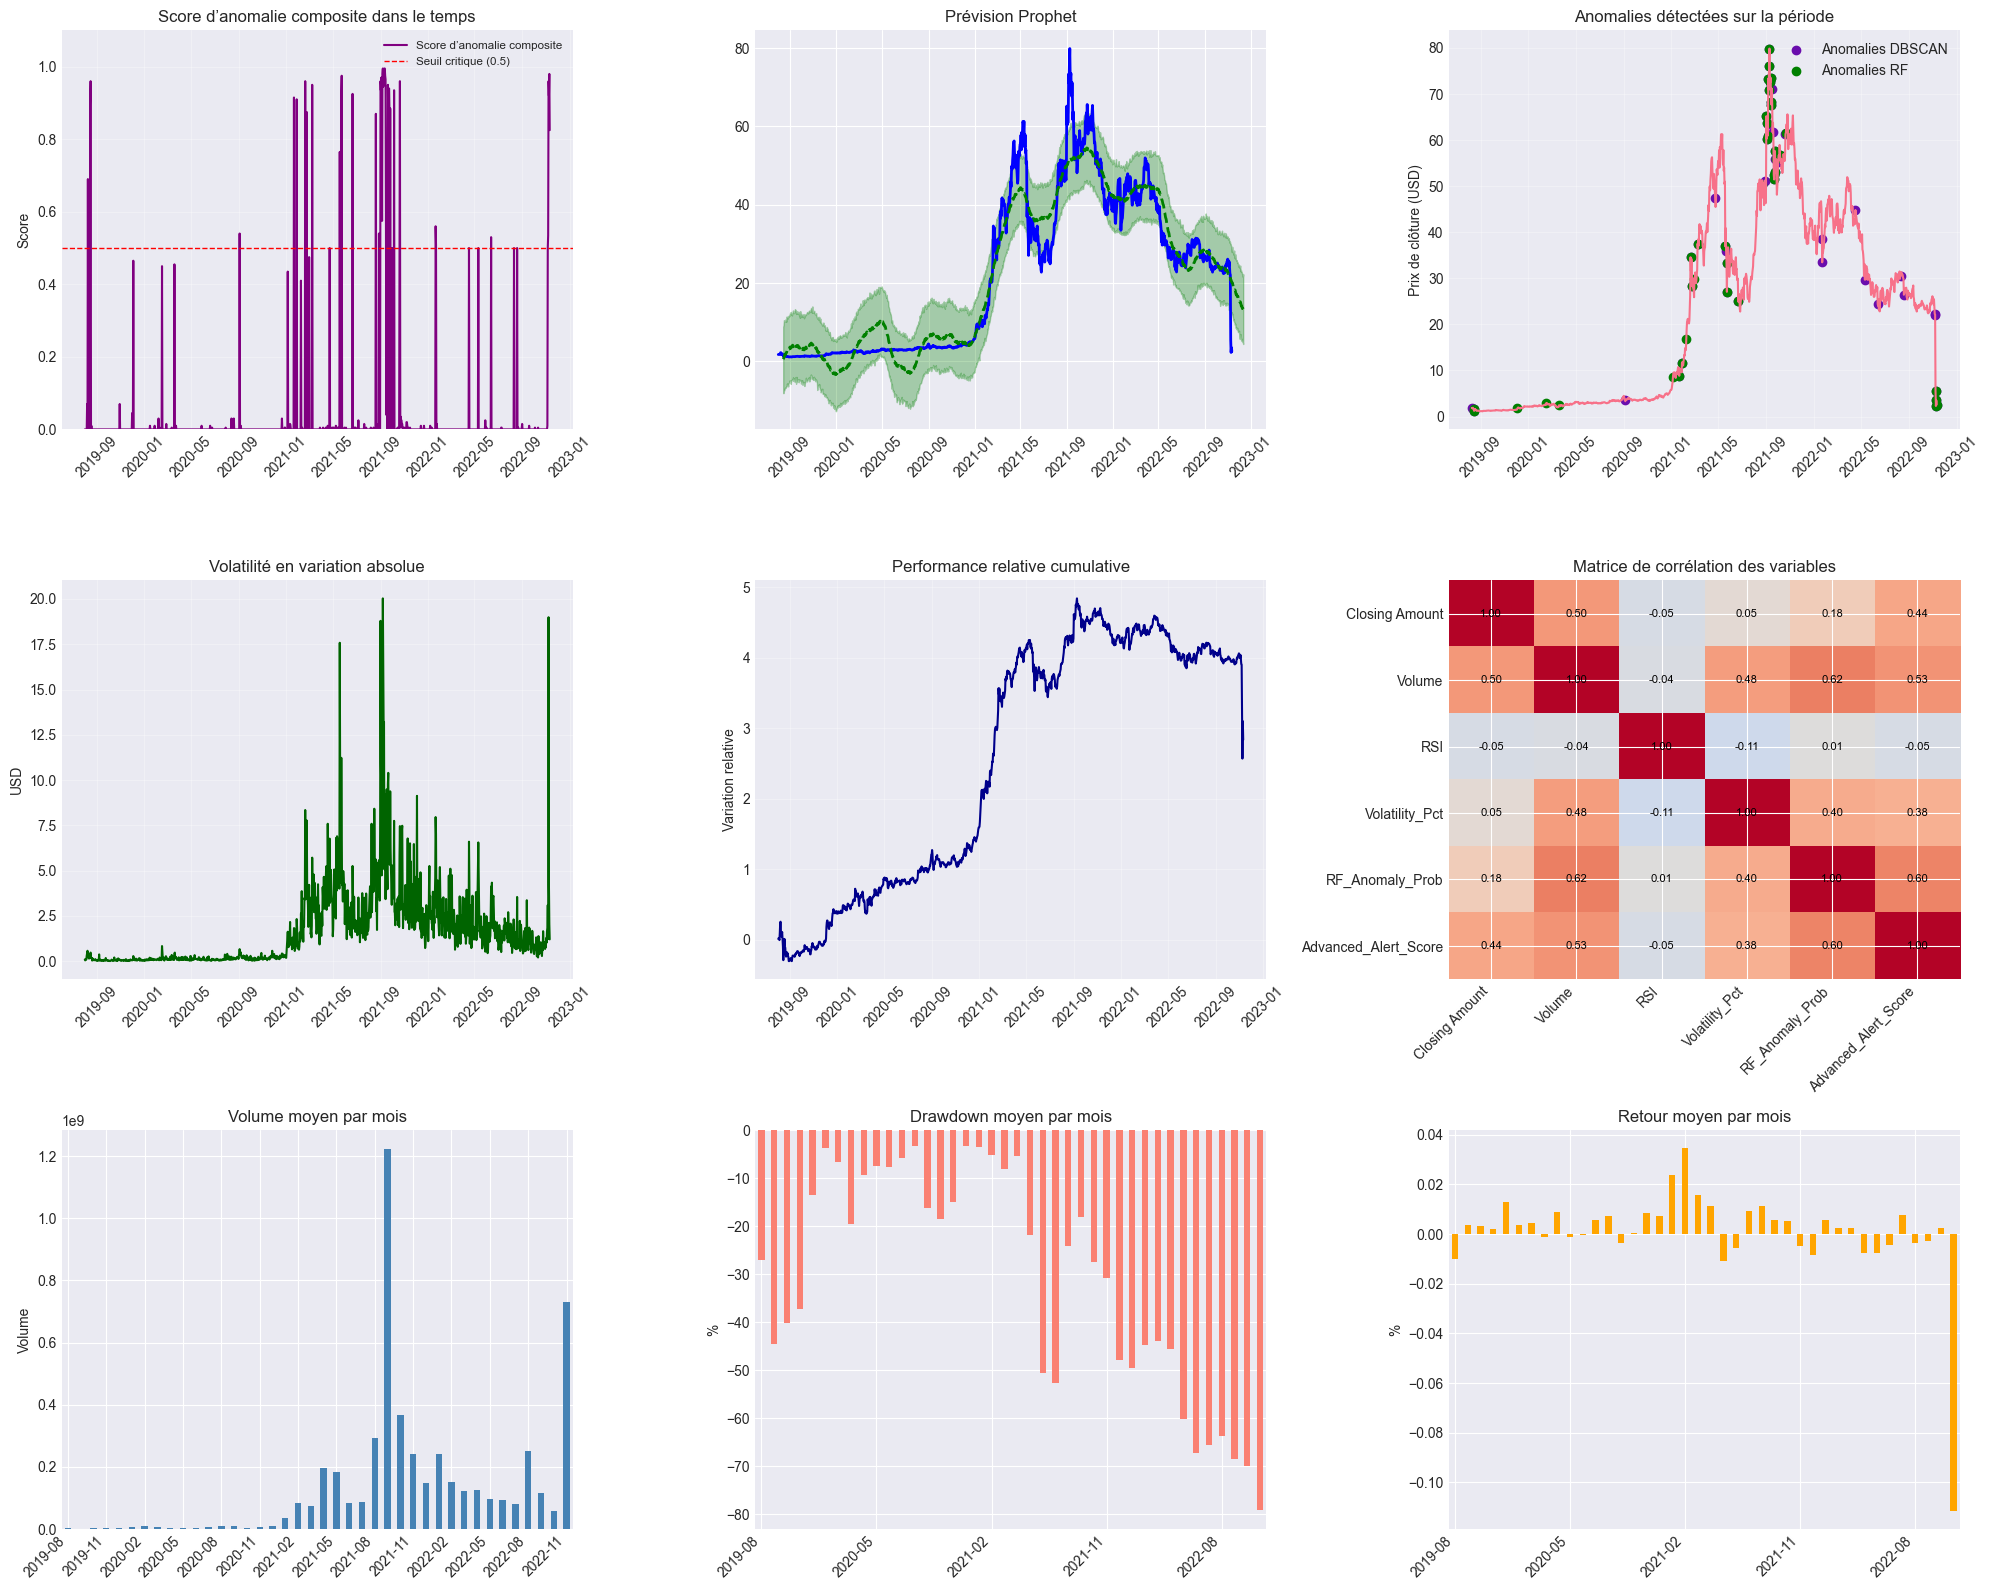

------------------------------------------------------------
Période critique détectée du 2019-08-09 au 2022-11-11

Statistiques descriptives de la période critique:
       Closing Amount       Return  Volatility_Pct  Composite_Anomaly_Score
count     1191.000000  1191.000000     1191.000000              1191.000000
mean        22.343401     0.002166        6.940741                 0.040319
std         19.994378     0.058085       12.102276                 0.175119
min          1.150000    -0.750678        0.757576                 0.000000
25%          2.935000    -0.020181        3.440012                 0.000000
50%         24.060000     0.001174        5.200946                 0.000000
75%         39.830000     0.026525        7.941173                 0.000000
max         79.870000     0.530435      344.021739                 0.995000

Nombre d'anomalies DBSCAN dans la période critique: 56
Nombre d'anomalies RF dans la période critique: 42
Nombre d'alertes critiques dans la période 

In [1]:
# ANALYSE DE L'EFFONDREMENT DE FTX
# ________________________________________________________________
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from prophet import Prophet 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


# 1. PREPARATION DES DONNEES - CALCULS
# ________________________________________________________________

# Définition de la classe 

class FTXAnalysisAdvanced:
    def __init__(self):
        self.df = None
        self.alerts = None
        self.models_performance = {}
        self.prophet_model = None
        self.prophet_forecast = None
        self.rf_anomaly_model = None
        self.dbscan_model = None
        
    def load_and_preprocess_data(self):
        """Chargement et preprocessing des données"""
        
        # Téléchargement des données
        path = kagglehub.dataset_download("parasharmanas/fall-of-ftx")
        self.df = pd.read_csv(os.path.join(path, "The Dataset.csv"))
        self.df["Date"] = pd.to_datetime(self.df["Date"], errors="coerce")
        
        # Nettoyage des colonnes 
        columns = ["Opening Amount", "Closing Amount", "Highest Amount", 
                         "Lowest Amount", "Volume", "Market Cap"]
        
        for col in columns:
            self.df[col] = pd.to_numeric(
                self.df[col].astype(str)
                .str.replace(r"[\$,]", "", regex=True),
                errors='coerce'
            )
        self.df = self.df.dropna(subset=columns)
        self.df = self.df.sort_values("Date").reset_index(drop=True)
        
        # Calculs de base
        self._calculate_basic_indicators()
        
        print(f"Données chargées: {len(self.df)} observations d'août 2019 à novembre 2022")
        return self.df.describe()
    
    def _calculate_basic_indicators(self):
        """Calcul des indicateurs de base"""
        # Utilisés pour la suite de l'analyse 
        self.df["Return"] = self.df["Closing Amount"].pct_change()
        self.df["Volatility"] = self.df["Highest Amount"] - self.df["Lowest Amount"]
        self.df["Volatility_Pct"] = self.df["Volatility"] / self.df["Closing Amount"] * 100
        
        # Drawdown
        self.df["Cumulative_Max"] = self.df["Closing Amount"].cummax()
        self.df["Drawdown"] = (self.df["Closing Amount"] - self.df["Cumulative_Max"]) / self.df["Cumulative_Max"] * 100
        
    def calculate_other_indicators(self):       
        # RSI Relative Strength Index avec moyenne sur 14j
        # Force et vitesse du mvmt de prix (surachat/survente si proche de 0)
        def calculate_rsi(prices, window=14):
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))
        
        self.df['RSI'] = calculate_rsi(self.df['Closing Amount'])
        
        # MACD
        exp1 = self.df['Closing Amount'].ewm(span=12).mean()
        exp2 = self.df['Closing Amount'].ewm(span=26).mean()
        self.df['MACD'] = exp1 - exp2

# ANOMALIES AVEC DBSCAN ET RANDOM FOREST
# ________________________________________________________________
            
    def detect_anomalies(self):
        
        features = ["Closing Amount", "Volume", "Return"]
        X = self.df[features].dropna()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 1. DBSCAN
        self.dbscan_model = DBSCAN(eps=0.5, min_samples=5)
        dbscan_labels = self.dbscan_model.fit_predict(X_scaled)
        self.df.loc[X.index, 'DBSCAN_Anomaly'] = (dbscan_labels == -1)
        self.df['DBSCAN_Anomaly'] = self.df['DBSCAN_Anomaly'].fillna(False)
        
        # 2. RandomForest
        # Création d'étiquettes d'anomalies basées sur des seuils statistiques
        volume_extreme = self.df['Volume'] > self.df['Volume'].quantile(0.98)
        return_extreme = self.df['Return'].abs() > self.df['Return'].abs().quantile(0.98)
        close_drop = self.df['Closing Amount'].pct_change() < -0.15  # ex : chute > 15% sur une journée
        # Combinaison des critères
        synthetic_anomalies = volume_extreme | return_extreme | close_drop
        
        # Préparation des données d'entraînement avec uniquement 3 variables
        X_rf = self.df[['Volume', 'Closing Amount', 'Return']].copy()
        X_rf = X_rf.fillna(0)  # pour gérer le NaN de la 1ère ligne (Return)
        y_rf = synthetic_anomalies.loc[X_rf.index]

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
          X_rf, y_rf, test_size=0.3, random_state=42, stratify=y_rf
          )

        # Modèle RandomForest
        self.rf_anomaly_model = RandomForestClassifier(
             n_estimators=100, random_state=42, class_weight='balanced' 
             )
        self.rf_anomaly_model.fit(X_train, y_train)

        # Prédictions
        rf_predictions = self.rf_anomaly_model.predict(X_rf)
        rf_probabilities = self.rf_anomaly_model.predict_proba(X_rf)[:, 1]
        
        self.df.loc[X_rf.index, 'RF_Anomaly'] = rf_predictions
        self.df.loc[X_rf.index, 'RF_Anomaly_Prob'] = rf_probabilities
        self.df['RF_Anomaly'] = self.df['RF_Anomaly'].fillna(False)
        self.df['RF_Anomaly_Prob'] = self.df['RF_Anomaly_Prob'].fillna(0)

        # Évaluation
        y_pred = self.rf_anomaly_model.predict(X_test)
        print(classification_report(y_test, y_pred))

        # On combine les détéctions DBSCAN et RF poru avoir un score composite 
        self.df['Composite_Anomaly_Score'] = (
            self.df['DBSCAN_Anomaly'].astype(int) + 
            self.df['RF_Anomaly_Prob']
        ) / 2
        
        self.df['Is_Anomaly'] = self.df['Composite_Anomaly_Score'] > 0.5
        # Une observation est une anomalie si son score est supérieur à 0.5
        # On calcule le nombre total d'anomalies en DBSCAN, RF et composite 
        n_dbscan = self.df['DBSCAN_Anomaly'].sum()
        n_rf = self.df['RF_Anomaly'].sum()
        n_composite = self.df['Is_Anomaly'].sum()
        
        print(f"Anomalies DBSCAN: {n_dbscan}")
        print(f"Anomalies RandomForest: {n_rf}")
        print(f"Anomalies composites: {n_composite}")

# PREDICTION DU PRIX DE CLOTURE (30j)
# ________________________________________________________________
        
    def prophet_forecasting(self, forecast_days=30):
        
        prophet_data = self.df[['Date', 'Closing Amount']].copy()
        prophet_data.columns = ['ds', 'y']
        prophet_data = prophet_data.dropna()
        
        self.prophet_model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,       # on prend en compte la saisonnalité (annonces...)
            changepoint_prior_scale=0.05,  # sensibilité aux changements de tendance
            seasonality_prior_scale=0.1,
            interval_width=0.95
        )
        
        prophet_data_with_regressors = prophet_data.merge(
            self.df[['Date', 'Volume', 'RSI']].rename(columns={'Date': 'ds'}),
            on='ds', how='left'
        )

        prophet_data_with_regressors['Volume'] = pd.to_numeric(prophet_data_with_regressors['Volume'], errors='coerce')
        prophet_data_with_regressors['RSI'] = pd.to_numeric(prophet_data_with_regressors['RSI'], errors='coerce')
        prophet_data_with_regressors['ds'] = pd.to_datetime(prophet_data_with_regressors['ds'], errors='coerce')
        prophet_data_with_regressors = prophet_data_with_regressors.dropna()

        prophet_data_with_regressors = prophet_data_with_regressors.dropna()
        # On choisit ces deux variables en tant que régresseurs car on cherche à estimer le prix de clôture
        self.prophet_model.add_regressor('Volume')
        self.prophet_model.add_regressor('RSI')

        try:
            self.prophet_model.fit(prophet_data_with_regressors)
            
            # Création du dataframe futur
            future = self.prophet_model.make_future_dataframe(periods=forecast_days)
            
            # Régresseurs futurs estimés à l'aide de valeurs passées (moyennes)
            #future['Volume'] = future['Volume'].fillna(prophet_data_with_regressors['Volume'].mean())
            #future['RSI'] = future['RSI'].fillna(prophet_data_with_regressors['RSI'].mean())
            # S'assurer que les colonnes existent AVANT de remplir
            if 'Volume' not in future.columns:
                 future['Volume'] = np.nan
            if 'RSI' not in future.columns:
                 future['RSI'] = np.nan

            # Maintenant on peut remplir avec des moyennes
            future['Volume'] = future['Volume'].fillna(prophet_data_with_regressors['Volume'].mean())
            future['RSI'] = future['RSI'].fillna(prophet_data_with_regressors['RSI'].mean())

            # Prévision
            self.prophet_forecast = self.prophet_model.predict(future)
            
            print(f"Prévision Prophet créée pour {forecast_days} jours")
            
            # On évalue la performance sur les données existantes 
            historical_forecast = self.prophet_forecast[:-forecast_days]
            actual_values = prophet_data_with_regressors['y'].values
            predicted_values = historical_forecast['yhat'].values[:len(actual_values)] #vec taille identique
            
            mae = mean_absolute_error(actual_values, predicted_values)
            r2 = r2_score(actual_values, predicted_values)
            
            self.models_performance['Prophet'] = {
                'MAE': mae,
                'R2': r2,
                'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
            }

        # Vérifier si l'entrainement Prophet est possible et quelles variables posent problème    
        except Exception as e:
            print(f"Erreur lors de l'entraînement Prophet: {e}")
            self.prophet_forecast = None

# ALERTES
# ________________________________________________________________
    
    def create_alert_system(self):
        
        # Alertes
        self.df['Drawdown_Alert'] = self.df['Drawdown'] < -15
        vol_threshold = self.df['Volatility_Pct'].quantile(0.95)
        self.df['Volatility_Alert'] = self.df['Volatility_Pct'] > vol_threshold
        self.df['RSI_Alert'] = (self.df['RSI'] < 30) | (self.df['RSI'] > 70)
        
        # Alertes machine learning (composite et RM)
        self.df['ML_Anomaly_Alert'] = self.df['Is_Anomaly']
        self.df['High_Prob_Anomaly_Alert'] = self.df['RF_Anomaly_Prob'] > 0.8
        
        # Alerte Prophet 
        if self.prophet_forecast is not None:
            # Détection d'écarts importants entre prédiction et réalité
            forecast_subset = self.prophet_forecast[:-30]  # exclure les prévisions futures
            actual_subset = self.df['Closing Amount'].iloc[:len(forecast_subset)]
            
            prediction_errors = np.abs(actual_subset - forecast_subset['yhat'].iloc[:len(actual_subset)])
            error_threshold = prediction_errors.quantile(0.9)
            
            self.df['Prophet_Alert'] = False
            self.df.loc[:len(forecast_subset)-1, 'Prophet_Alert'] = prediction_errors > error_threshold
        else:
            self.df['Prophet_Alert'] = False
        
        # Score composite d'alerte avancé
        alert_cols = ['Drawdown_Alert', 'Volatility_Alert', 'RSI_Alert', 
                     'ML_Anomaly_Alert', 'High_Prob_Anomaly_Alert', 'Prophet_Alert']
        self.df['Advanced_Alert_Score'] = self.df[alert_cols].sum(axis=1)
        self.df['Critical_Risk'] = self.df['Advanced_Alert_Score'] >= 3
        
        n_critical = self.df['Critical_Risk'].sum()
        print(f"{n_critical} périodes à risque critique identifiées")
    
    def risk_metrics(self):
        """Calcul des métriques de risque essentielles"""
        
        returns = self.df['Return'].dropna()
        
        # VaR à différents niveaux
        var_1 = np.percentile(returns, 1)
        var_5 = np.percentile(returns, 5)
        var_10 = np.percentile(returns, 10)
        
        # Expected Shortfall (CVaR) perte moyenne conditionnée au fait qu'on dépasse la VaR à 5%
        # 5% = Bâle III
        cvar_5 = returns[returns <= var_5].mean()
        
        # Maximum Drawdown
        max_drawdown = self.df['Drawdown'].min()
        
        # Volatilité annualisée avec 252 trading days en moyenne 
        annual_volatility = returns.std() * np.sqrt(252) * 100
        
        # Ratio de Sharpe (on pose un taux sans risque = 0) 
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
        
        self.risk_metrics = {
            'VaR_1%': f"{var_1:.4f}",
            'VaR_5%': f"{var_5:.4f}",
            'VaR_10%': f"{var_10:.4f}",
            'CVaR_5%': f"{cvar_5:.4f}",
            'Max_Drawdown': f"{max_drawdown:.2f}%",
            'Annual_Volatility': f"{annual_volatility:.2f}%",
            'Sharpe_Ratio': f"{sharpe_ratio:.4f}"
        }
        return self.risk_metrics

# MODELISATION PREDICTIVE AVEC RANDOM FOREST
# ________________________________________________________________

    def prediction_rf(self):

        # Maintenant on veut prédire le closing amount ave RF
        features = ["Opening Amount", "Volume", "RSI", 
                   "Volatility_Pct", "MACD"]
        data_ml = self.df[features + ["Closing Amount"]].dropna()
        
        # Division train/test
        split_idx = int(len(data_ml) * 0.75)
        train_data = data_ml[:split_idx]
        test_data = data_ml[split_idx:]
        
        X_train = train_data[features]
        y_train = train_data["Closing Amount"]
        X_test = test_data[features]
        y_test = test_data["Closing Amount"]
        
        # Modèles multiples
        models = {
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'LinearRegression': LinearRegression()
        }
        
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            
            self.models_performance[name] = {
                'MAE': mae,
                'R2': r2,
                'MAPE': mape
            }
        
        # Feature importance pour RandomForest
        rf_model = models['RandomForest']
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Features les plus pertinentes:")
        for i, row in feature_importance.head(3).iterrows():
            print(f"   • {row['feature']}: {row['importance']:.4f}")
        
        return feature_importance

# GRAPHIQUES
# ________________________________________________________________

    def visualization(self):

        # Table
        fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    
        # 1. Scores d'anomalies
        ax1 = axes[0, 0]
        ax1.plot(
            self.df['Date'],
            self.df['Composite_Anomaly_Score'],
            color='purple',
            linewidth=1.5,
            label='Score d’anomalie composite'
            )
        ax1.axhline(0.5, color='red', linestyle='--', linewidth=1, label='Seuil critique (0.5)')
        ax1.set_title("Score d’anomalie composite dans le temps")
        ax1.set_ylabel("Score")
        ax1.set_xlabel("")
        ax1.set_ylim(0, 1.1)
        ax1.legend(loc='upper right', fontsize='small')
        ax1.grid(alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # 2. Prophet 
        ax2 = axes[0, 1]
        ax2.plot(self.df['Date'], self.df['Closing Amount'], 'b-', label='Prix réel', linewidth=2)
        forecast_dates = self.prophet_forecast['ds']
        ax2.plot(forecast_dates, self.prophet_forecast['yhat'], 'g--', label='Prévision Prophet', linewidth=2)
        ax2.fill_between(forecast_dates, self.prophet_forecast['yhat_lower'], self.prophet_forecast['yhat_upper'], alpha=0.3, color='green', label='Intervalle de confiance')
        ax2.set_title('Prévision Prophet')
        ax2.tick_params(axis='x', rotation=45)


        # 3. DBSCAN et RandomForest
        ax3 = axes[0, 2]
        critical = self.df[self.df['Critical_Risk']]
        if not critical.empty:
            start_date = critical['Date'].min()
            end_date = critical['Date'].max()
            period_df = self.df[(self.df['Date'] >= start_date) & (self.df['Date'] <= end_date)]
            ax3.plot(period_df['Date'], period_df['Closing Amount'], label='')
            ax3.scatter(period_df[period_df['DBSCAN_Anomaly']]['Date'], period_df[period_df['DBSCAN_Anomaly']]['Closing Amount'], color='#6a0dad', label='Anomalies DBSCAN')
            ax3.scatter(period_df[period_df['RF_Anomaly']]['Date'], period_df[period_df['RF_Anomaly']]['Closing Amount'], color='green', label='Anomalies RF')
            ax3.set_title('Anomalies détectées sur la période')
            ax3.set_ylabel('Prix de clôture (USD)')
            ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)

        # 4. Volatilité absolue
        ax4 = axes[1, 0]
        ax4.plot(self.df['Date'], self.df['Volatility'].abs(), color='darkgreen')
        ax4.set_title('Volatilité en variation absolue')
        ax4.set_ylabel('USD')
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)

        # 5. Performance relative
        ax5 = axes[1, 1]
        performance = self.df['Closing Amount'].pct_change().cumsum()
        ax5.plot(self.df['Date'], performance, color='darkblue')
        ax5.set_title('Performance relative cumulative')
        ax5.set_ylabel('Variation relative')
        ax5.grid(True, alpha=0.3)
        ax5.tick_params(axis='x', rotation=45)

        # 6. Matrice
        ax6 = axes[1, 2]
        corr_features = ['Closing Amount', 'Volume', 'RSI', 'Volatility_Pct', 'RF_Anomaly_Prob', 'Advanced_Alert_Score']
        corr_matrix = self.df[corr_features].corr()
        im = ax6.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax6.set_xticks(range(len(corr_features)))
        ax6.set_yticks(range(len(corr_features)))
        ax6.set_xticklabels(corr_features, rotation=45, ha='right')
        ax6.set_yticklabels(corr_features)
        ax6.set_title('Matrice de corrélation des variables')
        for i in range(len(corr_features)):
            for j in range(len(corr_features)):
                ax6.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

        # 7. KPI : Volume
        ax7 = axes[2, 0]
        self.df['YearMonth'] = self.df['Date'].dt.to_period('M').astype(str)
        kpi_volume = self.df.groupby('YearMonth')['Volume'].mean()
        kpi_volume.plot(kind='bar', ax=ax7, color='steelblue')
        ax7.set_title('Volume moyen par mois')
        ax7.set_ylabel('Volume')
        ax7.set_xlabel('')
        ax7.set_xticklabels(kpi_volume.index, rotation=45, ha='right')
        ax7.set_xticks(ax7.get_xticks()[::3])  # Une date sur trois

        # 8. KPI : Drawdown
        ax8 = axes[2, 1]
        kpi_drawdown = self.df.groupby('YearMonth')['Drawdown'].mean()
        kpi_drawdown.plot(kind='bar', ax=ax8, color='salmon')
        ax8.set_title('Drawdown moyen par mois')
        ax8.set_ylabel('%')
        ax8.set_xlabel('')
        ax8.set_xticklabels([str(p) for p in kpi_drawdown.index], rotation=45, ha='right')
        ax8.set_xticks(ax7.get_xticks()[::3])  # Une date sur trois

        # 9. KPI : Retour moyen
        ax9 = axes[2, 2]
        kpi_return = self.df.groupby('YearMonth')['Return'].mean()
        kpi_return.plot(kind='bar', ax=ax9, color='orange')
        ax9.set_title('Retour moyen par mois')
        ax9.set_ylabel('%')
        ax9.set_xlabel('')
        ax9.set_xticklabels([str(p) for p in kpi_return.index], rotation=45, ha='right')
        ax9.set_xticks(ax7.get_xticks()[::3])  # Une date sur trois

        plt.tight_layout()
        plt.show()

# RAPPORT - CONCLUSION 
# ________________________________________________________________            
    def generate_report(self):
        report = {
            'Informations générales': {
                'Période d\'analyse': f"{self.df['Date'].min().strftime('%Y-%m-%d')} à {self.df['Date'].max().strftime('%Y-%m-%d')}",
                'Nombre d\'observations': len(self.df),
                'Prix minimum': f"${self.df['Closing Amount'].min():.2f}",
                'Prix maximum': f"${self.df['Closing Amount'].max():.2f}",
            },
            'Détection d\'anomalies': {
                'Anomalies DBSCAN': int(self.df['DBSCAN_Anomaly'].sum()),
                'Anomalies RandomForest': int(self.df['RF_Anomaly'].sum()),
                'Anomalies composites': int(self.df['Is_Anomaly'].sum()),
                'Score moyen anomalie': f"{self.df['Composite_Anomaly_Score'].mean():.4f}"
            },
            'Système d\'alerte avancé': {
                'Périodes critiques': int(self.df['Critical_Risk'].sum()),
                'Score d\'alerte moyen': f"{self.df['Advanced_Alert_Score'].mean():.2f}",
                'Périodes avec score ≥ 3': int((self.df['Advanced_Alert_Score'] >= 3).sum())
            },
            'Performance des modèles': self.models_performance,
            'Métriques de risque': self.risk_metrics
        }
        return report
    
    def crash_period_analysis(self):
        """Analyse de la période de crash"""
        print("-" * 60)
        
    # Identifier la période de crash critique basée sur les alertes
        crash_period = self.df[self.df['Critical_Risk']]
        if crash_period.empty:
            print("Aucune période critique identifiée pour l'analyse approfondie.")
            return None

        start_date = crash_period['Date'].min()
        end_date = crash_period['Date'].max()
        period_df = self.df[(self.df['Date'] >= start_date) & (self.df['Date'] <= end_date)]

        # Affichage des dates clés
        print(f"Période critique détectée du {start_date.date()} au {end_date.date()}")

        # Statistiques de la période
        summary_stats = period_df[['Closing Amount', 'Return', 'Volatility_Pct', 'Composite_Anomaly_Score']].describe()
        print("\nStatistiques descriptives de la période critique:")
        print(summary_stats)

        # Compte des anomalies et alertes
        n_dbscan = period_df['DBSCAN_Anomaly'].sum()
        n_rf = period_df['RF_Anomaly'].sum()
        n_alerts = period_df['Critical_Risk'].sum()
        print(f"\nNombre d'anomalies DBSCAN dans la période critique: {n_dbscan}")
        print(f"Nombre d'anomalies RF dans la période critique: {n_rf}")
        print(f"Nombre d'alertes critiques dans la période critique: {n_alerts}")

        return {
            'start_date': start_date,
            'end_date': end_date,
            'summary_stats': summary_stats,
            'n_dbscan': int(n_dbscan),
            'n_rf': int(n_rf),
            'n_alerts': int(n_alerts)
        }


if __name__ == '__main__':
    analysis = FTXAnalysisAdvanced()
    analysis.load_and_preprocess_data()
    analysis.calculate_other_indicators()
    analysis.detect_anomalies()
    analysis.prophet_forecasting(forecast_days=30)
    analysis.create_alert_system()
    risk = analysis.risk_metrics()
    feature_imp = analysis.prediction_rf()
    analysis.visualization()
    report = analysis.generate_report()
    crash_info = analysis.crash_period_analysis()

    # Affichage du rapport final
    print("\nRapport:")
    for section, content in report.items():
        print(f"\n## {section}")
        print(content)
